### 0) mini config

In [26]:
INPUT_FOLDER = 'v00_original'
TRAIN_FILENAME = 'train.pkl'
TEST_FILENAME = 'test.pkl'


### 1) libs and consts

In [27]:
import os,sys,inspect,pickle #;sys.exit(sys.path) # sys.exit(np.array([5,52,12]))
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
gragrandparentdir = os.path.dirname(os.path.dirname(os.path.dirname(currentdir))) 
#sys.path.insert(0,gragrandparentdir) # pipeline-template
import time ;tic = time.time() #print(time.time()-tic,'sec')
import tqdm
import numpy as np
import pandas as pd
#import config
#import kglpipe
#path = gragrandparentdir + kglpipe.myconfig['PATH'] + INPUT_FOLDER # path = os.path.join(gragrandparentdir, kglpipe.myconfig['PATH']+INPUT_FOLDER)
parentdir

'C:\\Users\\user01\\Desktop\\sibur-production\\input\\activity-atactic'

### 2) read

In [28]:
train_data = pickle.load( open(os.path.join(parentdir, INPUT_FOLDER, TRAIN_FILENAME), "rb"))
test_data = pickle.load( open(os.path.join(parentdir, INPUT_FOLDER, TEST_FILENAME), "rb"))
activity_test_target = pd.read_csv(os.path.join(parentdir, INPUT_FOLDER, "activity_test_timestamps.csv"), index_col="date", parse_dates=["date"])
print('train',train_data.shape, 'test',test_data.shape, 'activity_test_target',activity_test_target.shape)#, 'atactic_test_target',atactic_test_target.shape)


train (463058, 60) test (103651, 56) activity_test_target (85891, 0)


In [29]:
print(list(train_data.index)[:1],list(train_data.index)[-1:])
print(list(test_data.index)[:1],list(test_data.index)[-1:])

[Timestamp('2018-02-13 08:30:00')] [Timestamp('2018-12-31 22:07:00')]
[Timestamp('2019-01-01 00:30:00')] [Timestamp('2019-03-14 00:00:00')]


In [30]:
test_data.index[0]

Timestamp('2019-01-01 00:30:00')

### 3) update
    step 1 'train' -----------------------------------------------------------------
    (463058, 60)  train           with 4 targets           (feb2018-dec2018)
    (463058, 4)   train_targets  (activity has 308313 not nulls)
    (103651, 56)  test           without 4 targets         (jan2019-mar2019)
    (566709, 55)  data           without 4 targets and f28
                   +
    (566709, 825) all_features    has its unique 825 (55x3x5) columns, generated from data
                   ||
    (566709, 880) full_data = data + all_features = without 4 targets and f28

    (463058, 881)  activity_train_with_nulls = train_targets[["activity"]] + full_data - rows
                               463058 x1                       566709 x880  

    (300737, 881) activity_train  (without rows with any NaN) save as train.pkl
    (103651, 880) activity_test  = full_data from jan2019 => useless! save as test_useless.pkl
    
    step 2 'test' -----------------------------------------------------------------
    (85891,    0) activity_test_target (empty csv with dates: jan2019-mar2019)
                    + (join, fillna)
    (566709, 880) full_data (see in top)
                    ||
    (85891,  880) test_activity_data  => real test! save as test.pkl
    
    conclusion: use only activity, add 825 cols to train, delete null rows and col f28
        * for testing - predict full_data from jan2019
        * for trainig - split activity_data on train/dev

In [31]:
data = pd.concat([train_data[test_data.columns], test_data]) ;print('data',data.shape) # use all columns except 4 targets
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy() ;print('train_targets',train_targets.shape)

data (566709, 56)
train_targets (463058, 4)


In [32]:
series = train_targets[['activity']].notnull().all(axis=1)
print(len(series[series==True]), 'rows without any null in whole row') # 300759 

308313 rows without any null in whole row


In [33]:
import pandas as pd
import numpy as np
rng = pd.date_range('2015-02-24', periods=5, freq='H') # freq='T'
df = pd.DataFrame({ 'Date': rng, 'Val1': range(len(rng)), 'Val2': range(1,len(rng)+1) })
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df.index = df['Date']
df = df.drop(columns=['Date'])
#     Date                  Val1 Val2  
#     2015-02-24 00:00:00   0     1
#     2015-02-24 01:00:00   1     2
#     2015-02-24 02:00:00   2     3
#     2015-02-24 03:00:00   3     4
#     2015-02-24 04:00:00   4     5
df.rolling('120MIN').aggregate('sum')
#     Date                 Val1    Val2
#     2015-02-24 00:00:00   0.0    1.0 # has no previous, but != NaN, cause date
#     2015-02-24 01:00:00   1.0    3.0 # currVal1 = 1; prev = 0; sum = 1
#     2015-02-24 02:00:00   3.0    5.0 # currVal1 = 2; prev = 1; sum = 3
#     2015-02-24 03:00:00   5.0    7.0
#     2015-02-24 04:00:00   7.0    9.0


,Val1,Val2
Date,,
2015-02-24 00:00:00,0.0,1.0
2015-02-24 01:00:00,1.0,3.0
2015-02-24 02:00:00,3.0,5.0
2015-02-24 03:00:00,5.0,7.0
2015-02-24 04:00:00,7.0,9.0


In [34]:
# generate 825 new cols from joineddata
#data.drop(['f28','f25','f42'], axis=1, inplace=True)
data.drop("f28", axis=1, inplace=True)
#ACOLS = ["atactic_1", "atactic_2", "atactic_3"]
#not_null_atactic = train_targets.loc[train_targets[ACOLS].notnull().all(axis=1), ACOLS] ;print(not_null_atactic.shape)
PERIODS = ["55MIN"]#['1D', '4D', '25D', '45D', '155D']#["5H", "4H", "6H"]#["1H", "3H", "6H"]
AGGREGATES = ["mean"]
#PERIODS = ["3H"]
#AGGREGATES = ["mean"]
all_features = []
for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        print(period,agg,end=',')
        rolling_features = data.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features)
all_features = pd.concat(all_features, axis=1) 
print('all_features',all_features.shape) #825/5/3 = 55 #15 new cols for each of 55 features 


55MIN mean,
all_features (566709, 55)


In [35]:
full_data = data.join(all_features)
#full_data = data
print('full_data',full_data.shape)


full_data (566709, 110)


In [36]:
# add col 'activity' from train to our data (train+test joined generated). 463058, cause in train so
activity_train_with_nulls = train_targets[["activity"]].join(full_data.shift(6, freq="H")) # add 6 hours empty rows to start, delete last 6 hours rows
print('activity_train_with_nulls',activity_train_with_nulls.shape)


activity_train_with_nulls (463058, 111)


In [37]:
series = activity_train_with_nulls.notnull().all(axis=1)
print(len(series[series==True]), 'rows without any null in whole row') # 300759 

300759 rows without any null in whole row


In [38]:
activity_train = activity_train_with_nulls[activity_train_with_nulls.notnull().all(axis=1)]
print('activity_train',activity_train.shape)


activity_train (300759, 111)


In [39]:
activity_test = full_data[full_data.index >= test_data.index[0]]
print('activity_test',activity_test.shape)


activity_test (103651, 110)


In [40]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill() # Synonym for DataFrame.fillna() with method='ffill'.
print('test_activity_data',test_activity_data.shape) # test_activity_data (85891, 880)

test_activity_data (85891, 110)


# ADDITION: get 1 month only

In [41]:
print(activity_train.index[0], activity_train.index[-1])


2018-02-13 14:30:00 2018-12-31 22:07:00


In [42]:
train = activity_train['2018-04-01 00:01:00':'2018-05-01 00:01:00']

2018-04-01 00:01:00 2018-05-01 00:01:00


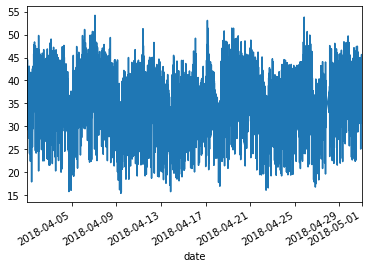

In [43]:
%matplotlib inline
print(train.index[0], train.index[-1])
train['activity'].plot()


In [44]:
original_features = ['activity'] + ['f'+str(i) for i in range(0,56)]
original_features.remove('f28')
print(original_features)
print('len=',len(original_features))

['activity', 'f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55']
len= 56


In [45]:
print(train.shape)

(42495, 111)


In [46]:
train_min = train[original_features]
train_min.shape

(42495, 56)

In [47]:
print('no  shift:',train_data['2018-04-01 00:01:00':][['f0','activity']].head(3))
print('yes shift:',train_min['2018-04-01 00:01:00':][['f0','activity']].head(3))




no  shift:                             f0   activity
date                                     
2018-04-01 00:01:00  37.695110  34.039165
2018-04-01 00:02:00  37.700569  35.229339
2018-04-01 00:03:00  37.696869  31.796342
yes shift:                             f0   activity
date                                     
2018-04-01 00:01:00  37.695240  34.039165
2018-04-01 00:02:00  37.695690  35.229339
2018-04-01 00:03:00  37.691181  31.796342


In [48]:
print('no  shift:',train_data['2018-04-01 00:01:00':][['f0','activity']].head(3))
print('yes shift:',train_min['2018-04-01 06:01:00':][['f0','activity']].head(3))

no  shift:                             f0   activity
date                                     
2018-04-01 00:01:00  37.695110  34.039165
2018-04-01 00:02:00  37.700569  35.229339
2018-04-01 00:03:00  37.696869  31.796342
yes shift:                             f0   activity
date                                     
2018-04-01 06:01:00  37.695110  34.074273
2018-04-01 06:02:00  37.700569  33.819251
2018-04-01 06:03:00  37.696869  32.013980


# conclusion: activity doesnt change, features moved fwd (features 6h before are used for current activity)

### 4) save


In [49]:
#activity_train.to_pickle(os.path.join(currentdir, "train.pkl"))
train_min.to_pickle(os.path.join(currentdir, "train.pkl"))
activity_test.to_pickle(os.path.join(currentdir, "test_useless.pkl"))
test_activity_data.to_pickle(os.path.join(currentdir, "test.pkl"))

print(time.time()-tic,'sec') # 173.91042184829712 sec

14.910157918930054 sec


### 5) test

In [50]:
# import time
# tic = time.time() 
# train_fun = pickle.load( open(os.path.join(currentdir, TRAIN_FILENAME+FORMAT), "rb"))
# test_fun = pickle.load( open(os.path.join(currentdir, TEST_FILENAME+FORMAT), "rb"))
# print('train_fun',train_fun.shape, 'test_fun',test_fun.shape)#, 'activity_test_timestamps',activity_test_timestamps.shape, 'atactic_test_timestamps',atactic_test_timestamps.shape)
# # train_fun (300737, 881) test_fun (103651, 880)
# print(time.time()-tic,'sec') # 27 sec
# # Split
# tr_data = train_fun[:"2018-10-13"]
# cv_data = train_fun["2018-10-14":]
# print('tr_data', tr_data.shape, 'cv_data',cv_data.shape) # tr_data (216400, 881) cv_data (84337, 881)
